**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
- [Sélection de 3 classes, échantillonnage, encodage, jeux de données](#toc2_)    
  - [Échantillonnage et encodage](#toc2_1_)    
  - [Configuration commune](#toc2_2_)    
  - [Jeux de données](#toc2_3_)    
- [Transfer Learning](#toc3_)    
  - [Fine-tuning total](#toc3_1_)    
  - [Extraction des features](#toc3_2_)    
  - [Fine-tuning partiel](#toc3_3_)    
- [Stratégie](#toc4_)    
- [VGG16](#toc5_)    
- [MobileNetV2](#toc6_)    
- [EfficientNet](#toc7_)    
- [Preuve avec 10 classes](#toc8_)    
  - [Échantillonnage et encodage](#toc8_1_)    
  - [Configuration](#toc8_2_)    
  - [Jeux de données](#toc8_3_)    
  - [Ré-entraînement pour 10 classes](#toc8_4_)    
- [Conclusion](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
from dotenv import load_dotenv
import os
import yaml
import shutil
import logging

# DS, ML & DL
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import Model
from keras.applications.vgg16 import VGG16
from keras.applications import EfficientNetB0, MobileNetV2
from keras.utils import image_dataset_from_directory
from keras.layers import Flatten, Dense
from keras.optimizers import AdamW

# images & data viz
import matplotlib.pyplot as plt

# home made functions from src folder
from src.get_data import get_tar_and_extract
from src.get_data import create_img_db
from src.models import eval_pretrained_model, ConditionalAugmentation

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

2024-07-31 15:48:22.147500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 15:48:22.191068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 15:48:23.040720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Configuration

In [2]:
# environment config
load_dotenv()
IMG_URL = os.getenv("IMG_URL")
ANNOT_URL = os.getenv("ANNOT_URL")

# local config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

CLASSES_3 = cfg["models"]["classes_3"]
CLASSES_10 = cfg["models"]["classes_10"]
DATA_DIR = cfg["data"]["local_path"]
IMG_DIR = os.path.join(DATA_DIR, cfg["data"]["img_dir"])
ANNOT_DIR = os.path.join(DATA_DIR, cfg["data"]["annot_dir"])
IMG_DB_URI = os.path.join(DATA_DIR, cfg["data"]["img_db_uri"])
TRAIN_DIR = os.path.join(DATA_DIR, cfg["data"]["train_dir"])
TEST_DIR = os.path.join(DATA_DIR, cfg["data"]["test_dir"])
CHKPT_DIR = os.path.join(DATA_DIR, cfg["data"]["checkpoint_dir"])
APP_DIR = os.path.join(DATA_DIR, cfg["data"]["app_dir"])
TRAIN_DIR_10 = TRAIN_DIR + "_10"
TEST_DIR_10 = TEST_DIR + "_10"
LOG_DIR = cfg["log"]["log_dir"]

Images et annotations, création de la BDD

In [3]:
if os.path.exists(IMG_DB_URI):
    img_df = pd.read_csv(IMG_DB_URI, index_col=0)
else:
    # download, extract and store data
    print("⚙️ Downloading images...")
    get_tar_and_extract(IMG_URL, DATA_DIR)
    print("⚙️ Downloading annotations...")
    get_tar_and_extract(ANNOT_URL, DATA_DIR)
    print("⚙️ Creating database...")

    # create database
    img_df = create_img_db(IMG_DIR, ANNOT_DIR, IMG_DB_URI)

# <a id='toc2_'></a>[Sélection de 3 classes, échantillonnage, encodage, jeux de données](#toc0_)

Conservation des classes vues dans le notebook précédent :
- Carlin (*pug*),
- Husky de Sibérie (*Siberian_husky*),
- Barzoï (*borzoi*)

171.5 images per class, 443.0 avg width, 386.0 avg height


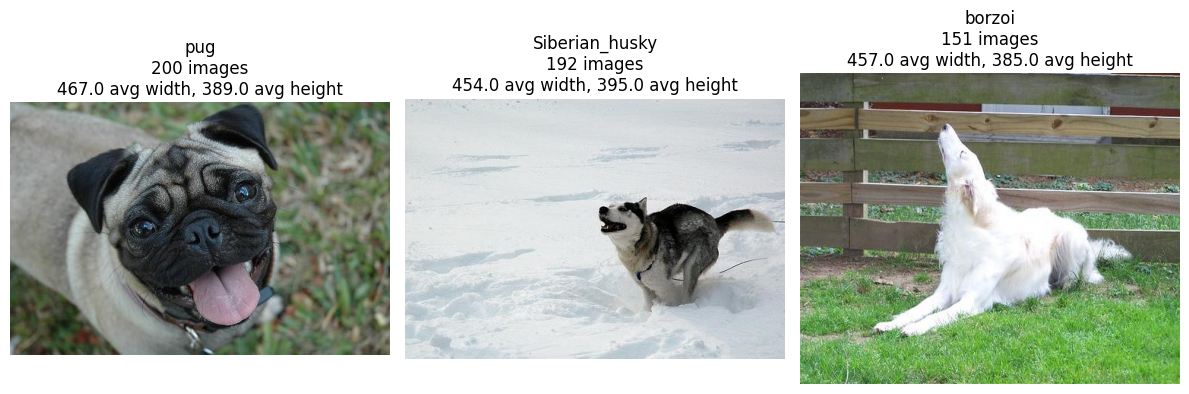

original shape (20580, 10) -> selected (543, 10)


In [4]:
m_n_img = img_df["class_label"].value_counts().values.mean()
m_w = img_df["width"].mean().round(0)
m_h = img_df["height"].mean().round(0)

print(f"{m_n_img} images per class, {m_w} avg width, {m_h} avg height")

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

for i, c in enumerate(CLASSES_3):
    _ = img_df.loc[img_df["class_label"] == c]

    # n images
    n_img = _["ID"].nunique()
    # mean width
    m_w = _["width"].mean().round(0)
    # mean height
    m_h = _["height"].mean().round(0)

    # pick image
    img = Image.open(_["img_uri"].to_list()[0])

    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(f"{c}\n{n_img} images\n{m_w} avg width, {m_h} avg height")

plt.tight_layout()
plt.show()
plt.close()

img_ds = img_df.loc[img_df["class_label"].isin(CLASSES_3)]
print(f"original shape {img_df.shape} -> selected {img_ds.shape}")

## <a id='toc2_1_'></a>[Échantillonnage et encodage](#toc0_)

In [5]:
y = img_ds["class_label"]
X = img_ds["img_uri"]

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# create samples directories
if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
if not os.path.exists(CHKPT_DIR):
    os.makedirs(CHKPT_DIR)


def copy_images(X, dir) -> None:
    i = 0
    for src_uri in X:
        img_name = src_uri.split("/")[-1]
        img_class = src_uri.split("/")[-2].split("-")[-1]
        dest_uri = os.path.join(dir, img_class, img_name)
        # create folder if needed
        if not os.path.exists(os.path.join(dir, img_class)):
            os.makedirs(os.path.join(dir, img_class))
        # copy image
        if not os.path.exists(dest_uri):
            shutil.copy2(src_uri, dest_uri)
        # count processed images
        i += 1
    print(f"{i} images processed")


copy_images(X_train, TRAIN_DIR)
copy_images(X_test, TEST_DIR)

488 images processed
55 images processed


## <a id='toc2_2_'></a>[Configuration commune](#toc0_)

In [6]:
input_size = (224, 224)
batch_size = 48
n_epochs = 100
optimizer = AdamW(learning_rate=0.0002, weight_decay=0.05)
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

Cette configuration permet de compiler des modèles, qui seront tous entraînés de la même manière :

``` python
model_trained, history = eval_pretrained_model(
    model=insert_model_here,
    train_ds=insert_train_ds_here,
    val_ds=insert_val_ds_here,
    test_ds=insert_test_ds_here,
    LOG_DIR=LOG_DIR,
    CHKPT_DIR=CHKPT_DIR,
    model_name=model_name,
    input_size=input_size,
    batch_size=batch_size,
    n_epochs=n_epochs,
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)
```

## <a id='toc2_3_'></a>[Jeux de données](#toc0_)

In [7]:
print("Train / val datasets:")
train_ds, val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    validation_split=0.2,  # train / val split
    subset="both",  # returns both train and val datasets
    shuffle=True,  # shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

print("\nTest dataset:")
test_ds = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    shuffle=False,  # do not shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

Train / val datasets:
Found 488 files belonging to 3 classes.
Using 391 files for training.
Using 97 files for validation.

Test dataset:
Found 55 files belonging to 3 classes.


# <a id='toc3_'></a>[Transfer Learning](#toc0_)

Le *transfer learning* permet :
- l'économie de ressources et de temps
- le réentraînement des seules couches supérieures
- d'**éviter le surentraînement** puisque lors d'un apprentissage de zéro, le **nombre de paramètres à apprendre étant largement supérieur au nombre d'images**

Le choix du modèle se fait selon :
- le jeu de données d'entrée
- la similarité avec notre problématique
- la stratégie adoptée

## <a id='toc3_1_'></a>[Fine-tuning total](#toc0_)

**Lorsque la nouvelle collection d'images est grande**, on peut se permettre d'entraîner tout le réseau sans courir le risque de sur-entraînement et comme les paramètres de toutes les couches (sauf de la dernière) sont initialement ceux du réseau pré-entraîné, la phase d'apprentissage sera faite plus rapidement que si l'initialisation avait été aléatoire.

On **remplace la dernière couche** (dense) du réseau pré-entraîné par un **classifieur adapté au nouveau problème** et **initialisé de manière aléatoire** → toutes les couches sont ensuite entraînées sur les nouvelles images.

> ➡️ cette stratégie n'est donc pas applicable ici car la collection d'images est petite (150 à 200 images par classe)

## <a id='toc3_2_'></a>[Extraction des features](#toc0_)

**Lorsque la nouvelle collection d'images est petite** entraîner un réseau complet mènerait à un sur-entraînement.  
**Si elle est en plus similaire aux images de pré-entraînement**, on peut **se servir des features du réseau pré-entraîné pour représenter les images du nouveau problème** car les nouvelles images peuvent alors être représentées par les mêmes features.

Pour cela, on **retire la dernière couche dense** et on **fixe tous les autres paramètres** → le réseau va calculer la représentation de chaque image à partir des features déjà apprises lors du pré-entraînement.  
On entraîne alors un **classifieur, initialisé aléatoirement**, sur ces représentations pour résoudre le nouveau problème.

> ➡️ cette stratégie pourrait être applicable ici à condition d'avoir un modèle pré-entraîné sur des images assez similaires

## <a id='toc3_3_'></a>[Fine-tuning partiel](#toc0_)

Cette stratégie est utilisée **lorsque la nouvelle collection d'images est petite mais très différente** des images du pré-entraînement :
- comme il y a peu d'images d'entraînement, la stratégie de fine-tuning total n'est pas envisageable à cause du risque d'overfitting
- les nouvelles images ont très peu de points communs avec les anciennes : utiliser les features du réseau pré-entraîné pour les représenter n'est pas une bonne idéé

Il s'agit **compromis** mélangeant les stratégies précédentes : on **remplace la dernière couche dense par le nouveau classifieur initialisé aléatoirement**, et on **fixe les paramètres de certaines couches** du réseau pré-entraîné.  
Ainsi, **en plus du classifieur**, on entraîne sur les nouvelles images les **couches non-fixées**, qui correspondent en général aux plus hautes couches du réseau.

> ➡️ cette stratégie pourrait être applicable, si par exemple on dispose d'un modèle performant mais n'ayant jamais vu d'images de chien

# <a id='toc4_'></a>[Stratégie](#toc0_)

Afin d'économiser des ressources, les modèles choisis sont des **modèles entraînés eux aussi sur ImageNet**.  
Pour rappel, le Stanford Dogs Dataset est issue du jeu de données ImageNet, ces modèles **ne nécessitent qu'une extraction de features**.

> #### ⚠️ Fuite de données ?
> Effectivement, il y a une fuite de données car **les modèles entraînés sur ImageNet ont déjà vu les images issues du Stanford Dogs Dataset**.  
> Cependant :
> - ces modèles **n'ont pas été entraînés pour y détecter précisément les races de chiens** mais plutôt les objets ou sujets représentés, ce qui **enlève la fuite de données au niveau des couches supérieures**
> - ImageNet est composé de 1 281 167 images d'entraînement et 50k images de validation (+ 100k images de test), ce qui correspond à **1 331 167 images vues par le modèle**
> - les images utilisées dans le notebook sont très peu nombreuses sur le jeu de données total :
>   - pour le problème à 3 classes, **488 images** sont utilisées à l'entraînement, soit **< 0.0004%** des images vues par les modèles durant leur entraînement
>   - pour le problème à 10 classes, **1 578 images** sont utilisées à l'entraînement, soit **< 0.0012%**
> - enfin, une **augmentation des données de 40% est effectuée sur les images pour l'entraînement**, ce qui diminue encore la part de fuite de données
> 👉 Il est possible d'en déduire que la fuite de données, si elle existe en principe, a une **incidence négligeable sur l'apprentissage des modèles et les résultats inhérents**.

# <a id='toc5_'></a>[VGG16](#toc0_)

Cet ancien modèle de 2014 à l'architecture simple et régulière a permis à beaucoup de mieux comprendre les réseaux convolutionnels et est toujours un excellent point d'approche.  

Son innovation a résidé à la fois dans la grande profondeur de ses couches et dans la petite taille des filtres (3x3), permettant à l'époque de réduire le nombre de paramètres et de mieux préserver les caractéristiques spatiales essentielles.

<img src="https://user.oc-static.com/upload/2018/03/14/15209908694697_vgg-16-3dc.png">

Il est conçu pour détecter 1000 classes : lors du changement de classifieur on devra donc utiliser une **couche dense à 3 sorties** à la place de 1000.

- [Documentation Keras ici](https://keras.io/api/applications/vgg/#vgg16-function)

In [8]:
model_name = "vgg16_3c"

# load pre-trained VGG-16 without top layers
model = VGG16(
    weights="imagenet",  # pre-trained weights
    include_top=False,  # no dense layer
    input_shape=(input_size[0], input_size[1], 3),  # input shape
)
# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(inputs)
x = model(augmented)

# flatten output
x = Flatten()(x)
# for feature extraction only
for layer in model.layers:
    layer.trainable = False
# new FC layer for 3 classes classification
predictions = Dense(3, activation="softmax")(x)
# define new model
vgg16_3c = Model(inputs=inputs, outputs=predictions)
# display model summary
vgg16_3c.summary()

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conditional_augmentation        │ (None, 224, 224, 3)    │             0 │
│ (ConditionalAugmentation)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        75,267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,789,955 (56.42 MB)

 Trainable params: 75,267 (294.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

<img src="outputs/7_transfer/vgg16_3c_cmtx.png" height="400px">
<img src="outputs/7_transfer/vgg16_3c_metric.png" height="400px">
<img src="outputs/7_transfer/vgg16_3c_loss.png" height="400px">

➡️ Commentaires
- la précision est excellente
- le temps d'entraînement est relativement long : le modèle a atteint son point haut à la 13° époque
- l'apprentissage est très lent : 93" / époque pour apprendre sur 75k paramètres

# <a id='toc6_'></a>[MobileNetV2](#toc0_)

Après un tel entraînement, il est intéressant de tester un modèle plus léger et moins gourmand en ressources.

MobileNetV2 est justement désigné pour les architectures mobiles, avec des ressources donc bien plus limitées.  
Il s'agit d'une évolution de MobileNet, qui exploite des convolutions en profondeur séparables pour réduire la complexité computationnelle.  

L'innovation de MobileNetV2 est l'utilisation de **blocs MBConv** (*Mobile Inverted Bottleneck Convolution*) qui sont particulièrement efficaces pour réduire le nombre de paramètres tout en maintenant de bonnes performances, de goulots d'étranglement linéaires et de couches d'expansion.

- [Papier original révisé en mars 2019](https://arxiv.org/pdf/1801.04381v4)

<figure>
  <img src="outputs/mobilenetv2_2.png" height="360">
  <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_10.37.14_PM.png" height="360">
  <figcaption>Principes de convolutions séparables, de goulots linéaires et de couches d'expansion</figcaption>
</figure>

In [9]:
model_name = "MobileNetV2"

# load pre-trained model without top layers
model = MobileNetV2(
    weights="imagenet",  # pre-trained weights
    include_top=False,  # no dense layer
    input_shape=(input_size[0], input_size[1], 3),  # input shape
)
# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(inputs)
x = model(augmented)

# flatten output
x = Flatten()(x)
# for feature extraction only
for layer in model.layers:
    layer.trainable = False
# new FC layer for 3 classes classification
predictions = Dense(3, activation="softmax")(x)
# define new model
mobnetv2 = Model(inputs=inputs, outputs=predictions)
# display model summary
mobnetv2.summary()

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conditional_augmentation_1      │ (None, 224, 224, 3)    │             0 │
│ (ConditionalAugmentation)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │       188,163 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,446,147 (9.33 MB)

 Trainable params: 188,163 (735.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

<img src="outputs/7_transfer/MobileNetV2_cmtx.png" height="400px">
<img src="outputs/7_transfer/MobileNetV2_metric.png" height="400px">
<img src="outputs/7_transfer/MobileNetV2_loss.png" height="400px">

➡️ Commentaires
- la précision du modèle n'est pas bonne
- l'apprentissage est par contre très rapide car il a appris sur 188k paramètres à 11" / époque, soit plus de 20 fois plus rapide que VGG16

# <a id='toc7_'></a>[EfficientNet](#toc0_)

Daté de 2019, EfficientNet est issu du constat qu'une **mise à l'échelle composée** (*Compound Scaling*) c'est-à-dire uniforme du réseau convolutionnel est plus efficace que les pratiques qui consistaient à augmenter soit la **profondeur**, soit la **largeur** soit la **résolution**.  
EfficientNet bénéficie ainsi de modèles plus équilibrés et efficaces en terme de ressources computationnelles / nombre et poids des paramètres / précision.

Par ailleurs, cette famille de modèles permet une grande mise à l'échelle avec une base initiale déjà très performante.  
Il est intéressant de souligner que les blocs MBConv de MobileNet sont utilisés aussi dans ses architecture.

- [Papier original révisé sept. 2020](https://arxiv.org/pdf/1905.11946)

<img src="https://www.researchgate.net/publication/351057828/figure/fig2/AS:1022512410394634@1620797364891/The-structure-of-an-EfficientNetB0-model-with-the-internal-structure-of-MBConv1-and.png">

EfficientNet existe en plusieurs versions, notées de **B0 à B7**, avec des modèles de plus en plus larges et profonds.  
Vu le peu de ressources de la problématique, **le modèle le plus léger sera d'abord testé** et seulement si ses performances sont trop peu satisfaisantes, les modèles plus complexes seront abordés.

In [10]:
model_name = "EfficientNetB0"

# load pre-trained model without top layers
model = EfficientNetB0(
    weights="imagenet",  # pre-trained weights
    include_top=False,  # no dense layer
    input_shape=(input_size[0], input_size[1], 3),  # input shape
)
# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(inputs)
x = model(augmented)

# flatten output
x = Flatten()(x)
# for feature extraction only
for layer in model.layers:
    layer.trainable = False
# new FC layer for 3 classes classification
predictions = Dense(3, activation="softmax")(x)
# define new model
effnetB0 = Model(inputs=inputs, outputs=predictions)
# display model summary
effnetB0.summary()

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conditional_augmentation_2      │ (None, 224, 224, 3)    │             0 │
│ (ConditionalAugmentation)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │       188,163 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,237,734 (16.17 MB)

 Trainable params: 188,163 (735.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

<img src="outputs/7_transfer/EfficientNetB0_cmtx.png" height="400px">
<img src="outputs/7_transfer/EfficientNetB0_metric.png" height="400px">
<img src="outputs/7_transfer/EfficientNetB0_loss.png" height="400px">

➡️ Commentaires
- sa précision est presque parfaite
- il a effectué son apprentissage en seulement 5 époques
- ce modèle a le plus court temps d'apprentissage avec moins de 18" / époque pour 188k paramètres (soit presque 13 fois plus rapide que VGG16)
- les paramètres sont 3 fois plus légers que le modèle VGG
- pas besoin de tester les modèles EfficientNet plus complexes

# <a id='toc8_'></a>[Preuve avec 10 classes](#toc0_)

Pour un travail sur davantages de classes, le nombre d'époques maximales de la fonction early stopping a été réhaussé.

171.5 images per class, 443.0 avg width, 386.0 avg height


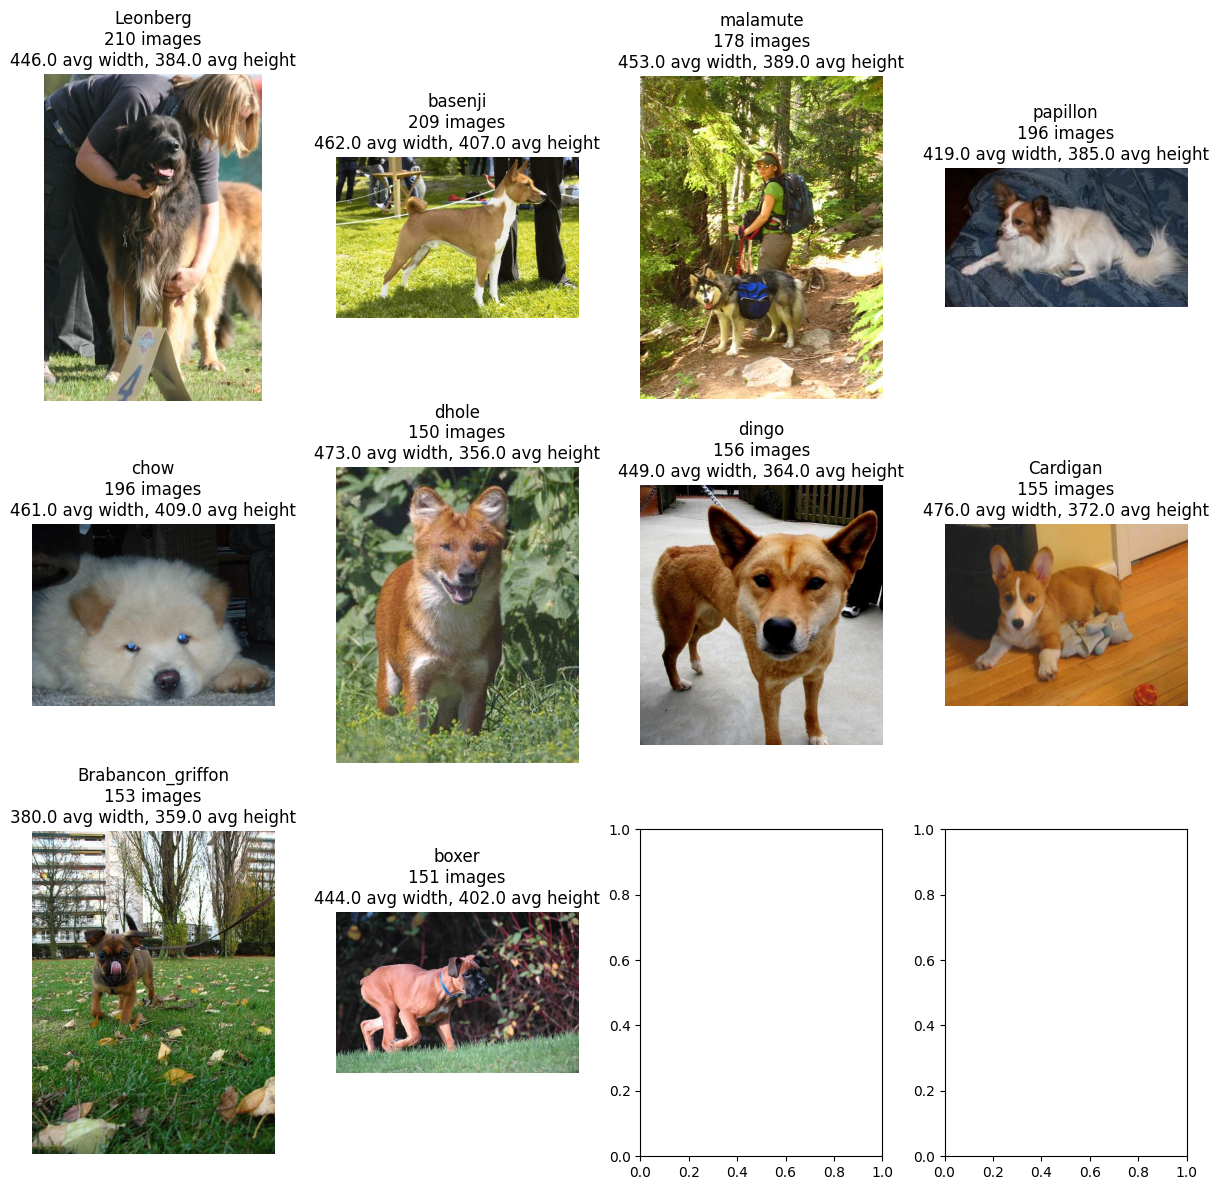

original shape (20580, 10) -> selected (1754, 10)


In [11]:
m_n_img = img_df["class_label"].value_counts().values.mean()
m_w = img_df["width"].mean().round(0)
m_h = img_df["height"].mean().round(0)

print(f"{m_n_img} images per class, {m_w} avg width, {m_h} avg height")

rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))

for i, c in enumerate(CLASSES_10):
    _ = img_df.loc[img_df["class_label"] == c]

    # n images
    n_img = _["ID"].nunique()
    # mean width
    m_w = _["width"].mean().round(0)
    # mean height
    m_h = _["height"].mean().round(0)

    # pick image
    img = Image.open(_["img_uri"].to_list()[0])

    row = i // cols
    col = i % cols
    axs[row][col].imshow(img)
    axs[row][col].axis("off")
    axs[row][col].set_title(f"{c}\n{n_img} images\n{m_w} avg width, {m_h} avg height")

plt.tight_layout()
plt.show()
plt.close()

img_ds = img_df.loc[img_df["class_label"].isin(CLASSES_10)]
print(f"original shape {img_df.shape} -> selected {img_ds.shape}")

## <a id='toc8_1_'></a>[Échantillonnage et encodage](#toc0_)

In [12]:
y = img_ds["class_label"]
X = img_ds["img_uri"]

# train / test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
# use some images in app folder
X_test, X_app, y_test, y_app = train_test_split(
    X_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=42
)

# create samples directories
if not os.path.exists(TRAIN_DIR_10):
    os.makedirs(TRAIN_DIR_10)
if not os.path.exists(TEST_DIR_10):
    os.makedirs(TEST_DIR_10)
if not os.path.exists(APP_DIR):
    os.makedirs(APP_DIR)

print("Train set: ")
copy_images(X_train, TRAIN_DIR_10)
print("Test set: ")
copy_images(X_test, TEST_DIR_10)
print("App set: ")
copy_images(X_app, APP_DIR)

Train set: 
1578 images processed
Test set: 
158 images processed
App set: 
18 images processed


## <a id='toc8_2_'></a>[Configuration](#toc0_)

In [13]:
input_size = (224, 224)
batch_size = 48
n_epochs = 100
optimizer = AdamW(learning_rate=0.0002, weight_decay=0.05)
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

## <a id='toc8_3_'></a>[Jeux de données](#toc0_)

In [14]:
print("Train / val datasets:")
train_ds_10, val_ds_10 = image_dataset_from_directory(
    TRAIN_DIR_10,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    validation_split=0.2,  # train / val split
    subset="both",  # returns both train and val datasets
    shuffle=True,  # shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

print("\nTest dataset:")
test_ds_10 = image_dataset_from_directory(
    TEST_DIR_10,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    shuffle=False,  # do not shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

Train / val datasets:
Found 1578 files belonging to 10 classes.
Using 1263 files for training.
Using 315 files for validation.

Test dataset:
Found 158 files belonging to 10 classes.


## <a id='toc8_4_'></a>[Ré-entraînement pour 10 classes](#toc0_)

In [15]:
model_name = "EfficientNetB0_10"

# load pre-trained model without top layers
model = EfficientNetB0(
    weights="imagenet",  # pre-trained weights
    include_top=False,  # no dense layer
    input_shape=(input_size[0], input_size[1], 3),  # input shape
)
# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(inputs)
x = model(augmented)

# flatten output
x = Flatten()(x)
# for feature extraction only
for layer in model.layers:
    layer.trainable = False
# new FC layer for 3 classes classification
predictions = Dense(10, activation="softmax")(x)
# define new model
effnetB0_10 = Model(inputs=inputs, outputs=predictions)
# display model summary
effnetB0_10.summary()

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conditional_augmentation_3      │ (None, 224, 224, 3)    │             0 │
│ (ConditionalAugmentation)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │       627,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,676,781 (17.84 MB)

 Trainable params: 627,210 (2.39 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

<img src="outputs/7_transfer/EfficientNetB0_10_cmtx.png" height="400px">
<img src="outputs/7_transfer/EfficientNetB0_10_metric.png" height="400px">
<img src="outputs/7_transfer/EfficientNetB0_10_loss.png" height="400px">

➡️ Commentaires
- le temps d'entraînement est très court par rapport au nombre de classes à apprendre
- ce modèle est très performant, avec des erreurs peu nombreuses et localisées majoritairement sur une classe
- un très bon compromis ressources / performances

# <a id='toc9_'></a>[Conclusion](#toc0_)

Les différents modèles testés montrent bien leurs différences lors de l'entraînement, même avec peu de classes à apprendre et des hyperparamètres similaires.

**EfficientNet a montré d'excellentes capacités**, même dans sa version minimale, tant pour 3 que pour 10 classes et sa relative légèreté (< 18Mo de paramètres) en fait un modèle de choix à implémenter dans l'application métier répondant à la problématique de cet exercice.